In [1]:
import pandas as pd                                       #importing pandas
import numpy as np                                        #importing numpy
import copy                                               
import random
import matplotlib.pyplot as plt                           #importing matplotlib 
import seaborn as sns                                     #importing seaborn
from sklearn.model_selection import train_test_split      #importing scikit-learn's function for data splitting
from sklearn.linear_model import LinearRegression         #importing scikit-learn's linear regressor function
from sklearn.neural_network import MLPRegressor           #importing scikit-learn's neural network function
from sklearn.ensemble import GradientBoostingRegressor    #importing scikit-learn's gradient booster regressor function
from sklearn.metrics import mean_squared_error            #importing scikit-learn's root mean squared error function for model evaluation
from sklearn.model_selection import cross_validate        #improting scikit-learn's cross validation function
import random
import time
from tqdm import tqdm
from scipy.stats import ks_2samp, kruskal

In [2]:
boxscores = pd.read_csv('https://raw.githubusercontent.com/Gurobi/modeling-examples/master/fantasy_basketball/boxscores_dataset.csv')     #load boxscores dataset
# running locally
# boxscores = pd.read_csv('boxscores_dataset.csv')     #laoad boxscores dataset
boxscores = boxscores[(boxscores.playMin>=3) | (boxscores.playMin.isnull())]

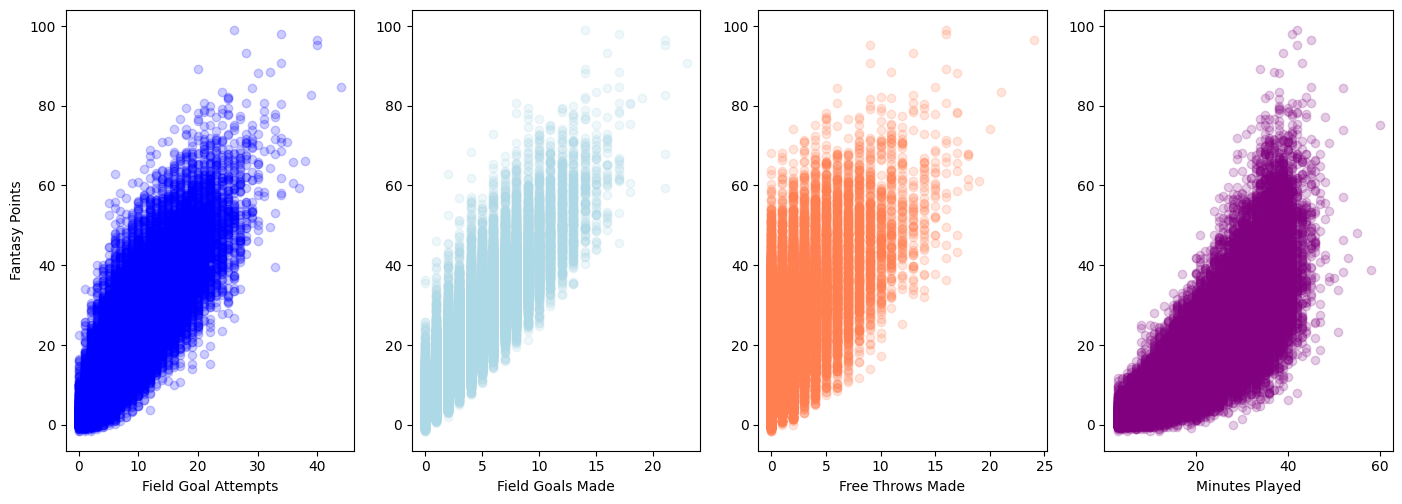

In [3]:
fig, (FGA, FGM, FTM, Min) = plt.subplots(1, 4, figsize=(14,5))
fig.tight_layout()

FGA.scatter(boxscores['playFGA'], boxscores['FantasyPoints'], c='blue', alpha = .2)
FGM.scatter(boxscores['playFGM'], boxscores['FantasyPoints'], c='lightblue', alpha = .2)
FTM.scatter(boxscores['playFTM'], boxscores['FantasyPoints'], c='coral', alpha = .2)
Min.scatter(boxscores['playMin'], boxscores['FantasyPoints'], c='purple', alpha = .2)

FGA.set_xlabel('Field Goal Attempts')
FGM.set_xlabel('Field Goals Made')
FTM.set_xlabel('Free Throws Made')
Min.set_xlabel('Minutes Played')

FGA.set_ylabel('Fantasy Points');

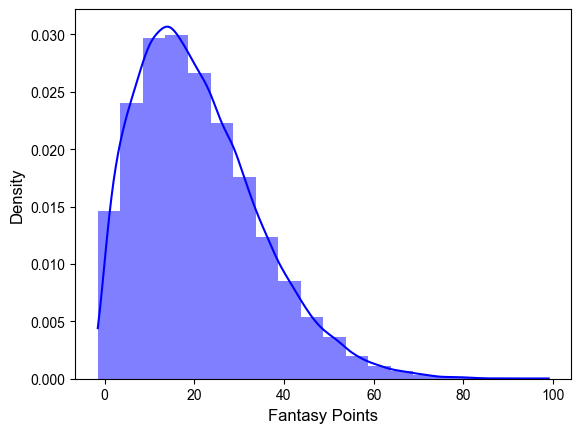

In [4]:
hplot = sns.histplot(boxscores['FantasyPoints'], color="blue", label="Fantasy Points", kde=True, stat="density", linewidth=0, bins=20)
hplot.set_xlabel("Fantasy Points", fontsize = 12)
hplot.set_ylabel("Density", fontsize = 12)
sns.set(rc={"figure.figsize":(14, 5)})

In [5]:
horizon=3

for column_name in ['playPTS','playAST','playTO','playSTL','playBLK','playTRB','playFGA','playFTA','play2P%','play3P%','playFT%','playMin','teamDayOff','FantasyPoints']:
    boxscores['moving' + column_name] = boxscores.groupby(['playDispNm'])[column_name].transform(lambda x: x.rolling(horizon, 1).mean().shift(1))                           #lagged moving average of numeric features 

In [6]:
boxscores.dropna(subset = ["movingplayPTS"], inplace=True)  

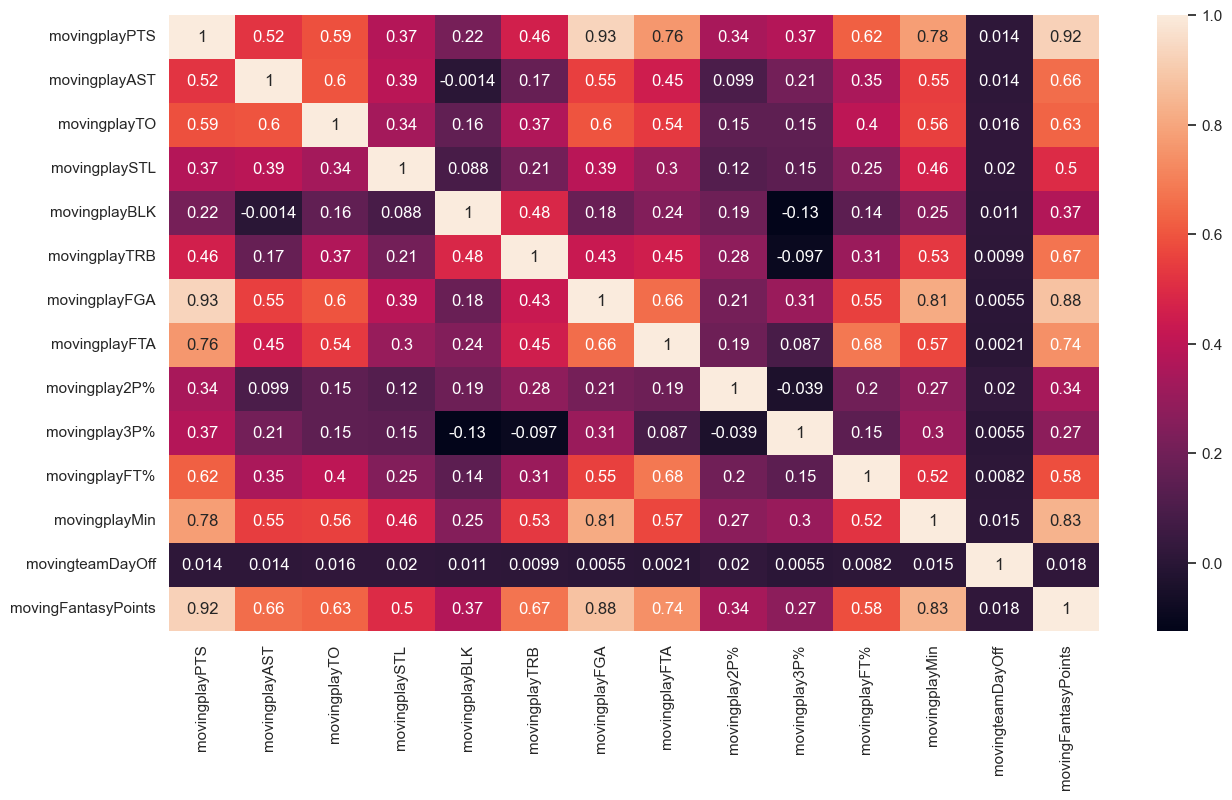

In [7]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(boxscores[['movingplayPTS', 'movingplayAST','movingplayTO','movingplaySTL','movingplayBLK','movingplayTRB','movingplayFGA','movingplayFTA','movingplay2P%','movingplay3P%','movingplayFT%','movingplayMin','movingteamDayOff','movingFantasyPoints']].corr(),annot=True)
plt.show()

In [8]:
boxscores['dummyTeamLoc'] = pd.get_dummies(data=boxscores['teamLoc'],drop_first=True)    #1 if the game is a home game, 0 if it is an away game
boxscores['dummyplayStat'] = pd.get_dummies(data=boxscores['playStat'],drop_first=True)  #1 if the player starts, 0 if the player comes from the bench

In [9]:
forecasting_data = boxscores[boxscores.gmDate != '2017-12-25']  #for model training, we exclude observation on December 25, 2017

In [10]:
X = forecasting_data[['movingplayAST','movingplayTO','movingplaySTL','movingplayBLK','movingplayTRB','movingplayFTA','movingplayFT%','dummyplayStat']]  #select the features that will be used for model training
y = forecasting_data['FantasyPoints']  #target set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)      #dataset splitting

linear_regressor = LinearRegression()                                                         #load linear regressor
linear_regressor.fit(X_train, y_train)                                                        #train the linear regression model
linear_regression_validation = cross_validate(linear_regressor, X_train, y_train, cv=5, return_train_score=True, return_estimator=True)

mlp = MLPRegressor(hidden_layer_sizes=(5,5), activation='relu')                               #load neural network
mlp.fit(X_train,y_train)                                                                      #train the neural network with a ReLU function and two hidden layers with 5 nodes each
mlp_validation = cross_validate(mlp, X_train, y_train, cv=5, return_train_score=True, return_estimator=True)

gb = GradientBoostingRegressor()                                                              #load a gradient boosting regressor
gb.fit(X_train, y_train)                                                                      #train a gradient boosting model
gb_validation = cross_validate(gb, X_train, y_train, cv=5, return_train_score=True, return_estimator=True)

In [11]:
gb_validation['test_score']                            #print CV test score across each fold

array([0.50943418, 0.49926381, 0.48128528, 0.49750968, 0.50056284])

In [12]:
linear_regression_predictions = linear_regressor.predict(X_test)                              #make predictions based on the test set for the linear regression model
mlp_predictions = mlp.predict(X_test)                                                         #make predictions based on the test set for the neural network model
gb_predictions = gb.predict(X_test)                                                           #make predictions based on the test set for the gradient boosting model

linear_regression_mse = mean_squared_error(y_test, linear_regression_predictions)             #calculate the MSE for the linear regression model
mlp_mse = mean_squared_error(y_test, mlp_predictions)                                         #calculate the MSE for the neural network model
gb_mse = mean_squared_error(y_test, gb_predictions)                                           #calculate the MSE for the gradient boosting model

results = {'Linear Regression':[linear_regression_mse],'ReLU Neural Network':[mlp_mse],'Gradient Boosting Regressor':[gb_mse]}
modeling_results = pd.DataFrame(data=results,index=['MSE'])

modeling_results

,Linear Regression,ReLU Neural Network,Gradient Boosting Regressor
MSE,91.077312,90.695395,90.667857


Text(967.9632352941177, 0.5, 'Gradient Boosting Residual')

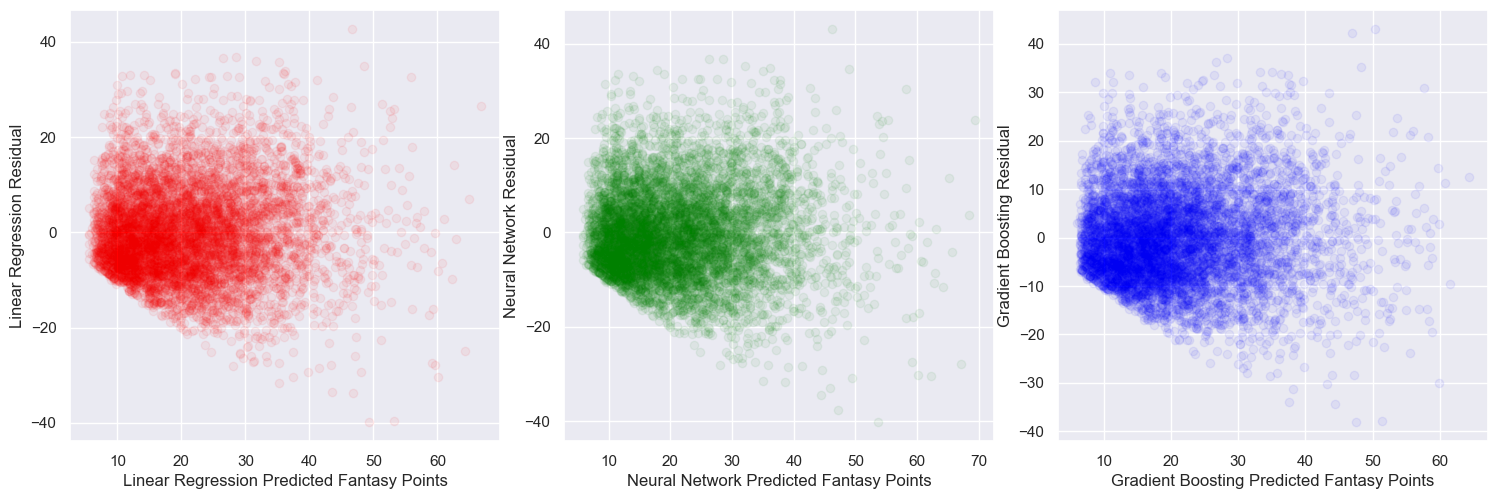

In [13]:
fig, (LR, FNN, GBR) = plt.subplots(1, 3,figsize=(15,5));
fig.tight_layout()

LR.scatter(x = linear_regression_predictions, y = y_test - linear_regression_predictions,color='red',alpha=0.06)
FNN.scatter(x = mlp_predictions, y = y_test - mlp_predictions, color='green',alpha=0.06)
GBR.scatter(x = gb_predictions, y = y_test - gb_predictions, color='blue',alpha=0.06)

LR.set_xlabel('Linear Regression Predicted Fantasy Points')
FNN.set_xlabel('Neural Network Predicted Fantasy Points')
GBR.set_xlabel('Gradient Boosting Predicted Fantasy Points')

LR.set_ylabel('Linear Regression Residual')
FNN.set_ylabel('Neural Network Residual')
GBR.set_ylabel('Gradient Boosting Residual')

In [14]:
gb_final = GradientBoostingRegressor(random_state=4)                                                             
gb_final.fit(X, y)   

optimization_dataset = boxscores
optimization_dataset['PredictedFantasyPoints'] = gb_final.predict(boxscores[['movingplayAST','movingplayTO','movingplaySTL','movingplayBLK','movingplayTRB','movingplayFTA','movingplayFT%','dummyplayStat']]) 

player_results = pd.read_csv('https://raw.githubusercontent.com/Gurobi/modeling-examples/master/fantasy_basketball/target_games.csv')
# player_results = pd.read_csv('target_games.csv')

predicted_fantasy_points = (
    optimization_dataset.query("gmDate == '2017-12-25'")
    [["playDispNm", "PredictedFantasyPoints"]]
)

player_results = pd.merge(
    left = player_results,
    right = predicted_fantasy_points,
    left_on = "Player",
    right_on = "playDispNm",
)

In [15]:
pd.set_option('display.expand_frame_repr', False)
player_results['Points/Salary Ratio'] = 1000*player_results['PredictedFantasyPoints']/player_results['Salary']    #we multiple the fantasy vs salary ratio by 1000 for better visualization
player_results.sort_values(by='PredictedFantasyPoints',ascending=False).head(5)

,Player,Pos,Team,Opp,Salary,playDispNm,PredictedFantasyPoints,Points/Salary Ratio
4,Joel Embiid,C,PHI,@ NYK,9500,Joel Embiid,51.313689,5.401441
0,James Harden,PG,HOU,@ OKC,11100,James Harden,48.809577,4.397259
1,LeBron James,SF,CLE,@ GSW,11000,LeBron James,48.149718,4.377247
2,Russell Westbrook,PG,OKC,vs HOU,10900,Russell Westbrook,44.007224,4.037360
3,Kevin Durant,SF,GSW,vs CLE,10500,Kevin Durant,43.438575,4.137007


In [16]:
indices = player_results.Player
points = dict(zip(indices, player_results.PredictedFantasyPoints))
salaries = dict(zip(indices, player_results.Salary))
positions = dict(zip(indices, player_results.Pos))

### Restricciones

In [17]:
SALARY_CAP = 30000
POSITIONS = {"PG": 1, "SG": 1, "SF": 1, "PF": 1, "C": 1}
# Crear un diccionario con los jugadores agrupados por posición
jugadores_por_posicion = {pos: [nombre for nombre in indices if positions[nombre] == pos] 
                          for pos in POSITIONS}

### PARÁMETROS DEL PSO

In [18]:
N = 50  # Número de partículas
it_max = 300  # Iteraciones máximas
c1 = 1  # Peso cognitivo
c2 = 1  # Peso social
w = 0.3 # Parámetro de inercia

### FUNCIÓN OBJETIVO: Ahora sin penalización

In [19]:
def fitness(team):
    """Calcula los fantasy points sin aplicar restricciones."""
    return sum(points[player] for player in team)

### GENERACIÓN DEL EQUIPO VÁLIDO (Asegura restricciones antes de fitness)

In [20]:
def generate_valid_team():
    """Genera un equipo que cumple con todas las restricciones."""
    while True:
        valid_team = []
        for pos in POSITIONS:
            valid_team.append(random.choice(jugadores_por_posicion[pos]))
        
        total_salary = sum(salaries[player] for player in valid_team)
        if total_salary <= SALARY_CAP:
            return valid_team  # Solo devuelve el equipo si cumple con el salario

### DEFINICIÓN DE PARTÍCULA

In [21]:
class Particle:
    def __init__(self):
        self.position = generate_valid_team()
        self.velocity = random.randint(1, 5)  # Inicializamos la velocidad (número de jugadores a cambiar) aleatoriamente entre 1 y 5
        self.best_position = self.position[:]
        self.best_fitness = fitness(self.position)

### PROCESO ITERATIVO DE PSO (Ahora con restricciones en `for`)

In [24]:
particles = [Particle() for _ in range(N)]

gbest_particle = max(particles, key=lambda p: p.best_fitness)
gbest_position = gbest_particle.best_position
gbest_fitness = gbest_particle.best_fitness

for it in range(it_max):
    for particle in particles:
        new_team = copy.deepcopy(particle.position)
        
        # Usamos la velocidad (número de cambios) para determinar cuántos jugadores cambiar
        indices_to_change = random.sample(range(len(new_team)), particle.velocity)

        for idx in indices_to_change:
            player = new_team[idx]
            pos_to_change = positions[player]

            # Aplicamos la actualización tipo PSO
            if random.random() < c1 / (c1 + c2):  # Influencia del mejor local
                new_team[idx] = particle.best_position[idx]
            elif random.random() < c2 / (c1 + c2):  # Influencia del mejor global
                new_team[idx] = gbest_position[idx]
            else:  # Exploración aleatoria
                new_team[idx] = random.choice((jugadores_por_posicion[pos_to_change]))
            
        #print(new_team)

        # Verificamos restricciones ANTES de calcular fitness
        total_salary = sum(salaries[player] for player in new_team)
        if total_salary <= SALARY_CAP:
            new_fitness = fitness(new_team)
            #print(new_fitness)

            # Actualizar mejor posición local
            if new_fitness > particle.best_fitness:
                particle.best_position = new_team[:]
                particle.best_fitness = new_fitness

            # Actualizar mejor posición global
            if new_fitness > gbest_fitness:
                gbest_position = new_team[:]
                gbest_fitness = new_fitness
                
        # Actualizamos la velocidad de la partícula
        particle.velocity = int(w * particle.velocity + c1 * random.random() * (particle.best_fitness - fitness(new_team)) + c2 * random.random() * (gbest_fitness - fitness(new_team)))
        # Asegurarnos de que la velocidad esté dentro del rango de valores válidos (1 a 5 cambios)
        particle.velocity = max(1, min(particle.velocity, 5))
        

    print(f"Iteración {it + 1}: Mejor puntuación = {gbest_fitness}")

Iteración 1: Mejor puntuación = 149.96315455932358
Iteración 2: Mejor puntuación = 159.01428065751847
Iteración 3: Mejor puntuación = 159.01428065751847
Iteración 4: Mejor puntuación = 159.01428065751847
Iteración 5: Mejor puntuación = 166.97073841070863
Iteración 6: Mejor puntuación = 166.97073841070863
Iteración 7: Mejor puntuación = 166.97073841070863
Iteración 8: Mejor puntuación = 166.97073841070863
Iteración 9: Mejor puntuación = 166.97073841070863
Iteración 10: Mejor puntuación = 166.97073841070863
Iteración 11: Mejor puntuación = 167.28203822649596
Iteración 12: Mejor puntuación = 168.53799262906475
Iteración 13: Mejor puntuación = 168.53799262906475
Iteración 14: Mejor puntuación = 168.53799262906475
Iteración 15: Mejor puntuación = 168.5827134094835
Iteración 16: Mejor puntuación = 168.5827134094835
Iteración 17: Mejor puntuación = 170.6677689768463
Iteración 18: Mejor puntuación = 170.6677689768463
Iteración 19: Mejor puntuación = 171.5424563583073
Iteración 20: Mejor puntua

### RESULTADO FINAL

In [23]:
best_team = gbest_position
print("\nEquipo óptimo seleccionado:")
for player in best_team:
    print(f"{player} - Posición: {positions[player]}, FantasyPoints: {points[player]}, Salary: {salaries[player]}")



Equipo óptimo seleccionado:
Josh Hart - Posición: PG, FantasyPoints: 24.26256418841442, Salary: 3700
Trevor Ariza - Posición: SG, FantasyPoints: 26.354156526577885, Salary: 5000
Paul George - Posición: SF, FantasyPoints: 36.398212282625806, Salary: 6800
Jordan Bell - Posición: PF, FantasyPoints: 33.08329620978338, Salary: 4900
Joel Embiid - Posición: C, FantasyPoints: 51.31368913047382, Salary: 9500


# Seleccion de sus parametros

## Número de partículas

Parametros de la prueba

In [32]:
# Lo ponemos en 600. Así si el experimento termina puede ser porque
# la población es demasiado pequeña y no se llega al valor óptimo
# la población es demasiado grande y el tiempo de ejecución entra
# en juego
it_max = 400

#tamaño de la población
particulas_values = np.linspace(100, 200, 3, dtype=int)

# Número de muestras para cada tamaño de población
num_pruebas = 50  

In [33]:
# Almacenamiento de resultados
resultados = []

for N in particulas_values:
    for prueba in range(num_pruebas):
        start_time = time.time()  # Iniciar tiempo
        particles = [Particle() for _ in range(N)]

        gbest_particle = max(particles, key=lambda p: p.best_fitness)
        gbest_position = gbest_particle.best_position
        gbest_fitness = gbest_particle.best_fitness

        for it in range(it_max):
            for particle in particles:
                new_team = copy.deepcopy(particle.position)
                
                # Usamos la velocidad (número de cambios) para determinar cuántos jugadores cambiar
                indices_to_change = random.sample(range(len(new_team)), particle.velocity)

                for idx in indices_to_change:
                    player = new_team[idx]
                    pos_to_change = positions[player]
                    
                    # Filtrar candidatos para esa posición
                    candidates = [p for p in indices if positions[p] == pos_to_change and p != player]

                    # Asegurar que siempre haya opciones válidas
                    if not candidates:
                        candidates = [p for p in indices if positions[p] == pos_to_change]

                    # Aplicamos la actualización tipo PSO
                    if random.random() < c1 / (c1 + c2):  # Influencia del mejor local
                        new_team[idx] = particle.best_position[idx]
                    elif random.random() < c2 / (c1 + c2):  # Influencia del mejor global
                        new_team[idx] = gbest_position[idx]
                    else:  # Exploración aleatoria
                        new_team[idx] = random.choice(candidates)
                    
                #print(new_team)

                # Verificamos restricciones ANTES de calcular fitness
                total_salary = sum(salaries[player] for player in new_team)
                if total_salary <= SALARY_CAP:
                    new_fitness = fitness(new_team)
                    #print(new_fitness)

                    # Actualizar mejor posición local
                    if new_fitness > particle.best_fitness:
                        particle.best_position = new_team[:]
                        particle.best_fitness = new_fitness

                    # Actualizar mejor posición global
                    if new_fitness > gbest_fitness:
                        gbest_position = new_team[:]
                        gbest_fitness = new_fitness

            if gbest_fitness >= 171.91:  # Si se alcanza la solución óptima, detener
                break

        tiempo_ejecucion = time.time() - start_time  # Tiempo de ejecución
        resultados.append({
            'n_particulas': N,
            'prueba': prueba,
            'mejor_fitness': gbest_fitness,
            'iteraciones': it,
            'tiempo': tiempo_ejecucion
        })

# Guardar resultados en un DataFrame
df_resultados = pd.DataFrame(resultados)
df_resultados.to_csv('resultados_pso_num_particulas2_100_200.csv', index=False)

Funciones para visualizar los resultados

In [46]:
def graficos(atributo, csv_file):
    # Cargar los datos
    df_resultados = pd.read_csv(csv_file)

    # Crear la figura con 3 subgráficos
    fig, axs = plt.subplots(1, 3, figsize=(18,6))

    # Gráfico 1: Tamaño población vs Iteraciones
    axs[0].scatter(df_resultados[atributo], df_resultados['iteraciones'], alpha=0.5)
    axs[0].set_title(atributo+' vs Iteraciones')
    axs[0].set_xlabel(atributo)
    axs[0].set_ylabel('Iteraciones')
    axs[0].set_ylim(0, 100)
    axs[0].grid(True)

    # Gráfico 2: Tamaño población vs Tiempo
    axs[1].scatter(df_resultados[atributo], df_resultados['tiempo'], alpha=0.5)
    axs[1].set_title(atributo+' vs tiempo')
    axs[1].set_xlabel(atributo)
    axs[1].set_ylabel('Tiempo')
    axs[1].set_ylim(0, 5)
    axs[1].grid(True)

    # Gráfico 3: Tamaño población vs Mejor fitness
    axs[2].scatter(df_resultados[atributo], df_resultados['mejor_fitness'], alpha=0.5)
    axs[2].set_title(atributo +' vs fitness')
    axs[2].set_xlabel(atributo)
    axs[2].set_ylabel('Fitness')
    axs[2].set_ylim(169, 172)
    axs[2].grid(True)

    # Ajustar el diseño y mostrar los gráficos
    plt.tight_layout()
    plt.show()


In [27]:
def tabla(atributo, csv):
    # Leer los datos desde el archivo CSV
    df = pd.read_csv(csv)

    # Cálculos estadísticos por tamaño de población
    estadisticas = df.groupby(atributo).agg(
        media_fitness=('mejor_fitness', 'mean'),
        mediana_fitness=('mejor_fitness', 'median'),
        cuartil_25_fitness=('mejor_fitness', lambda x: x.quantile(0.25)),
        cuartil_75_fitness=('mejor_fitness', lambda x: x.quantile(0.75)),
        media_iteraciones=('iteraciones', 'mean'),
        mediana_iteraciones=('iteraciones', 'median'),
        cuartil_25_iteraciones=('iteraciones', lambda x: x.quantile(0.25)),
        cuartil_75_iteraciones=('iteraciones', lambda x: x.quantile(0.75)),
        media_tiempo=('tiempo', 'mean'),
        mediana_tiempo=('tiempo', 'median'),
        cuartil_25_tiempo=('tiempo', lambda x: x.quantile(0.25)),
        cuartil_75_tiempo=('tiempo', lambda x: x.quantile(0.75))
    )

    # Mostrar las estadísticas
    print("\nEstadísticas por tamaño de población:")
    print(estadisticas)

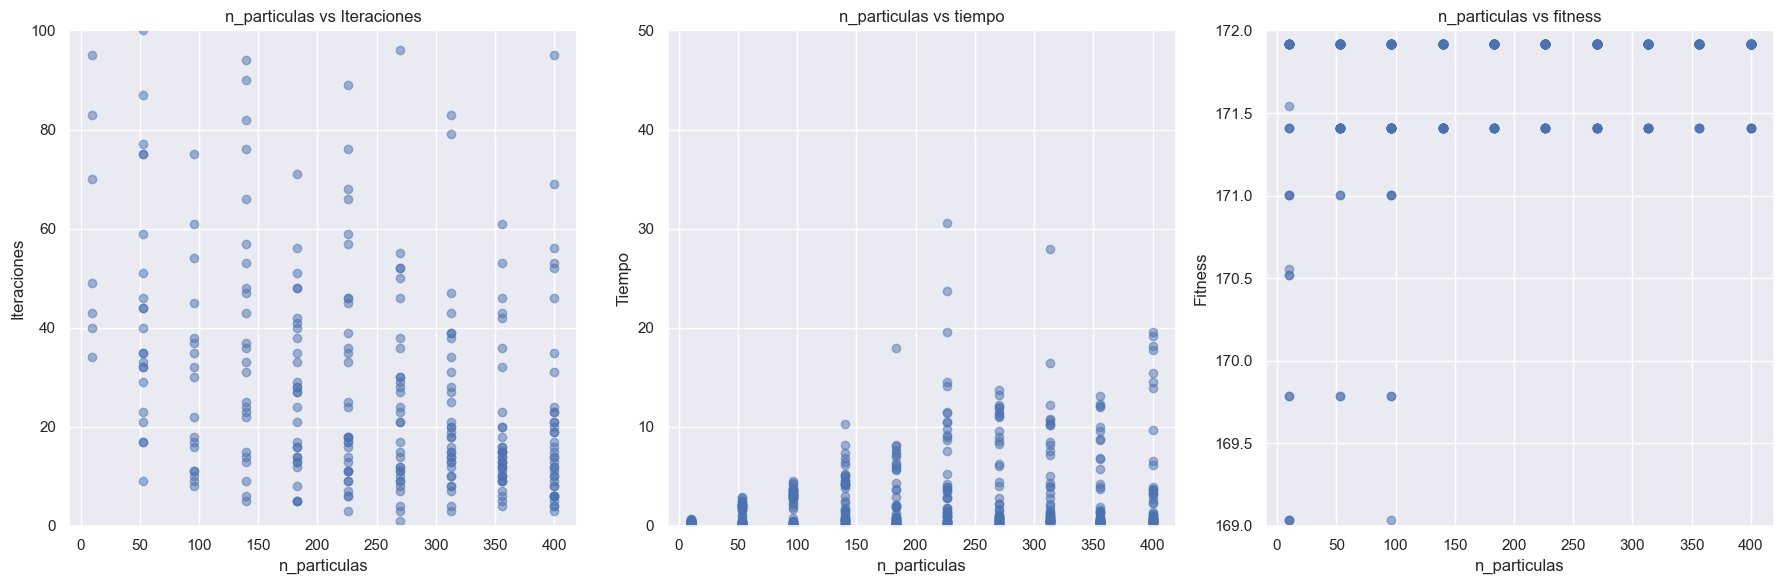

In [31]:
graficos('n_particulas', 'resultados_pso_num_particulas2.csv')

In [29]:
tabla('n_particulas', 'resultados_pso_num_particulas2.csv')


Estadísticas por tamaño de población:
              media_fitness  mediana_fitness  cuartil_25_fitness  cuartil_75_fitness  media_iteraciones  mediana_iteraciones  cuartil_25_iteraciones  cuartil_75_iteraciones  media_tiempo  mediana_tiempo  cuartil_25_tiempo  cuartil_75_tiempo
n_particulas                                                                                                                                                                                                                                    
10               169.752121       170.534905          168.233254          171.918929             316.08                399.0                  196.75                  399.00      0.317766        0.327163           0.167292           0.435274
53               171.524913       171.918929          171.411918          171.918929             210.60                150.0                   44.00                  399.00      1.113745        0.662918           0.250901           2.0073

Veamos los resultados entre 100 y 200, para ahcer tradeoff entre fitness y tiempo

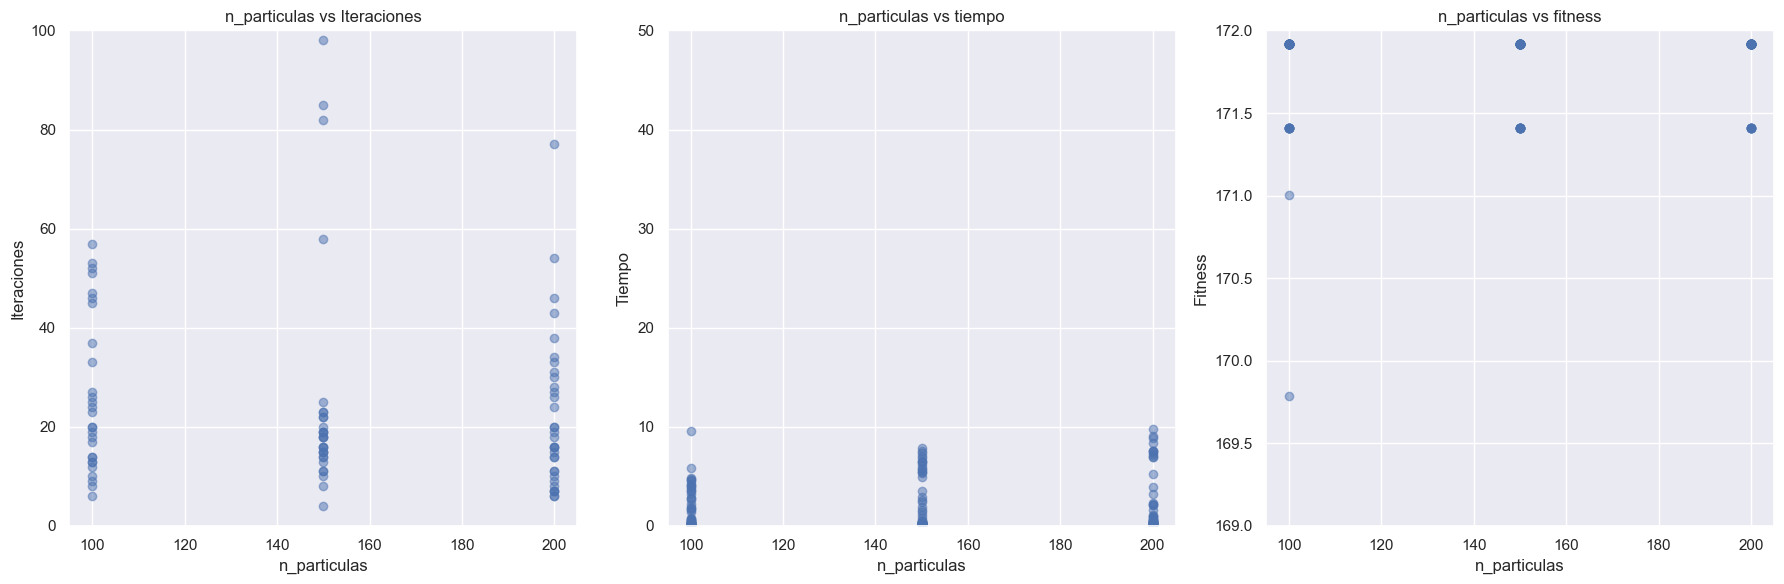

In [35]:
graficos('n_particulas', 'resultados_pso_num_particulas2_100_200.csv')

In [ ]:
tabla('n_particulas', 'resultados_pso_num_particulas2_100_200.csv')


Estadísticas por tamaño de población:
              media_fitness  mediana_fitness  cuartil_25_fitness  cuartil_75_fitness  media_iteraciones  mediana_iteraciones  cuartil_25_iteraciones  cuartil_75_iteraciones  media_tiempo  mediana_tiempo  cuartil_25_tiempo  cuartil_75_tiempo
n_particulas                                                                                                                                                                                                                                    
100              171.766751       171.918929          171.918929          171.918929             153.34                 51.5                   20.00                  362.00      1.846187        0.682952           0.273449           3.408175
150              171.684619       171.918929          171.538671          171.918929             148.06                 24.0                   16.00                  383.75      2.415199        0.522894           0.270993           5.4019

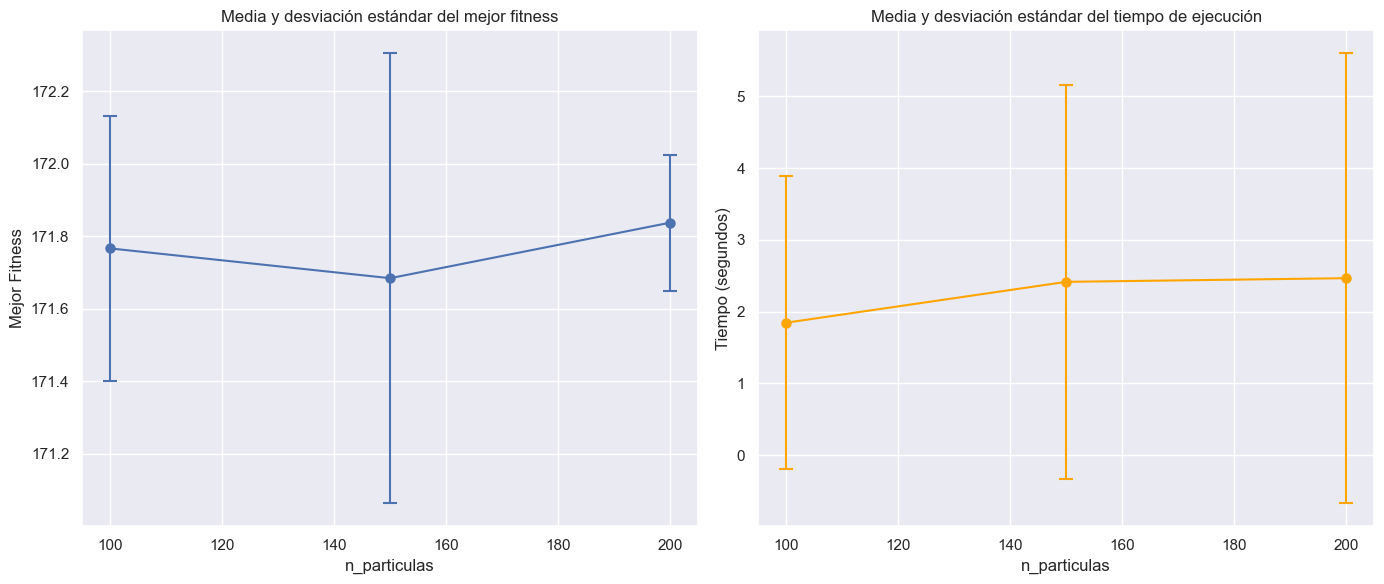

In [26]:
# Cargar los datos
df = pd.read_csv("resultados_pso_num_particulas2_100_200.csv")

# Agrupar por 'pc' y calcular media y desviación estándar del mejor fitness
summary_fitness = df.groupby("n_particulas")["mejor_fitness"].agg(['mean', 'std']).reset_index()

# Agrupar por 'pc' y calcular media y desviación estándar del tiempo de ejecución
summary_time = df.groupby("n_particulas")["tiempo"].agg(['mean', 'std']).reset_index()

# Crear figura con dos subgráficas
fig, axs = plt.subplots(1, 2, figsize=(14,6))

# Gráfica 1: Fitness
axs[0].errorbar(
    summary_fitness["n_particulas"],
    summary_fitness["mean"],
    yerr=summary_fitness["std"],
    fmt='-o',
    capsize=5,
    elinewidth=1.5,
    markeredgewidth=1.5
)
axs[0].set_title("Media y desviación estándar del mejor fitness")
axs[0].set_xlabel("n_particulas")
axs[0].set_ylabel("Mejor Fitness")
axs[0].grid(True)

# Gráfica 2: Tiempo de ejecución
axs[1].errorbar(
    summary_time["n_particulas"],
    summary_time["mean"],
    yerr=summary_time["std"],
    fmt='-o',
    capsize=5,
    elinewidth=1.5,
    markeredgewidth=1.5,
    color='orange'
)
axs[1].set_title("Media y desviación estándar del tiempo de ejecución")
axs[1].set_xlabel("n_particulas")
axs[1].set_ylabel("Tiempo (segundos)")
axs[1].grid(True)

plt.tight_layout()
plt.show()

Realizamos lo mismo pero para c1

In [38]:
N = 100 

c1_values = np.linspace(0.1, 10, 10, dtype=float)  # Peso cognitivo
c2 = 1  # Peso social

In [39]:
# Almacenamiento de resultados
resultados = []

for c1 in c1_values:
    for prueba in range(num_pruebas):
        start_time = time.time()  # Iniciar tiempo
        particles = [Particle() for _ in range(N)]

        gbest_particle = max(particles, key=lambda p: p.best_fitness)
        gbest_position = gbest_particle.best_position
        gbest_fitness = gbest_particle.best_fitness

        for it in range(it_max):
            for particle in particles:
                new_team = copy.deepcopy(particle.position)
                
                # Usamos la velocidad (número de cambios) para determinar cuántos jugadores cambiar
                indices_to_change = random.sample(range(len(new_team)), particle.velocity)

                for idx in indices_to_change:
                    player = new_team[idx]
                    pos_to_change = positions[player]
                    
                    # Filtrar candidatos para esa posición
                    # esto lo podriamos tener como una variable ya hecha, como el el algortimo de GA, y en caso de p = player seleccionamos otro y ya
                    candidates = [p for p in indices if positions[p] == pos_to_change and p != player]

                    # Asegurar que siempre haya opciones válidas
                    if not candidates:
                        candidates = [p for p in indices if positions[p] == pos_to_change]

                    # Aplicamos la actualización tipo PSO
                    if random.random() < c1 / (c1 + c2):  # Influencia del mejor local
                        new_team[idx] = particle.best_position[idx]
                    elif random.random() < c2 / (c1 + c2):  # Influencia del mejor global
                        new_team[idx] = gbest_position[idx]
                    else:  # Exploración aleatoria
                        new_team[idx] = random.choice(candidates)
                    
                #print(new_team)

                # Verificamos restricciones ANTES de calcular fitness
                total_salary = sum(salaries[player] for player in new_team)
                if total_salary <= SALARY_CAP:
                    new_fitness = fitness(new_team)
                    #print(new_fitness)

                    # Actualizar mejor posición local
                    if new_fitness > particle.best_fitness:
                        particle.best_position = new_team[:]
                        particle.best_fitness = new_fitness

                    # Actualizar mejor posición global
                    if new_fitness > gbest_fitness:
                        gbest_position = new_team[:]
                        gbest_fitness = new_fitness

            if gbest_fitness >= 171.91:  # Si se alcanza la solución óptima, detener
                break

        tiempo_ejecucion = time.time() - start_time  # Tiempo de ejecución
        resultados.append({
            'c1': c1,
            'prueba': prueba,
            'mejor_fitness': gbest_fitness,
            'iteraciones': it,
            'tiempo': tiempo_ejecucion
        })

# Guardar resultados en un DataFrame
df_resultados = pd.DataFrame(resultados)
df_resultados.to_csv('resultados_pso_c1_2.csv', index=False)

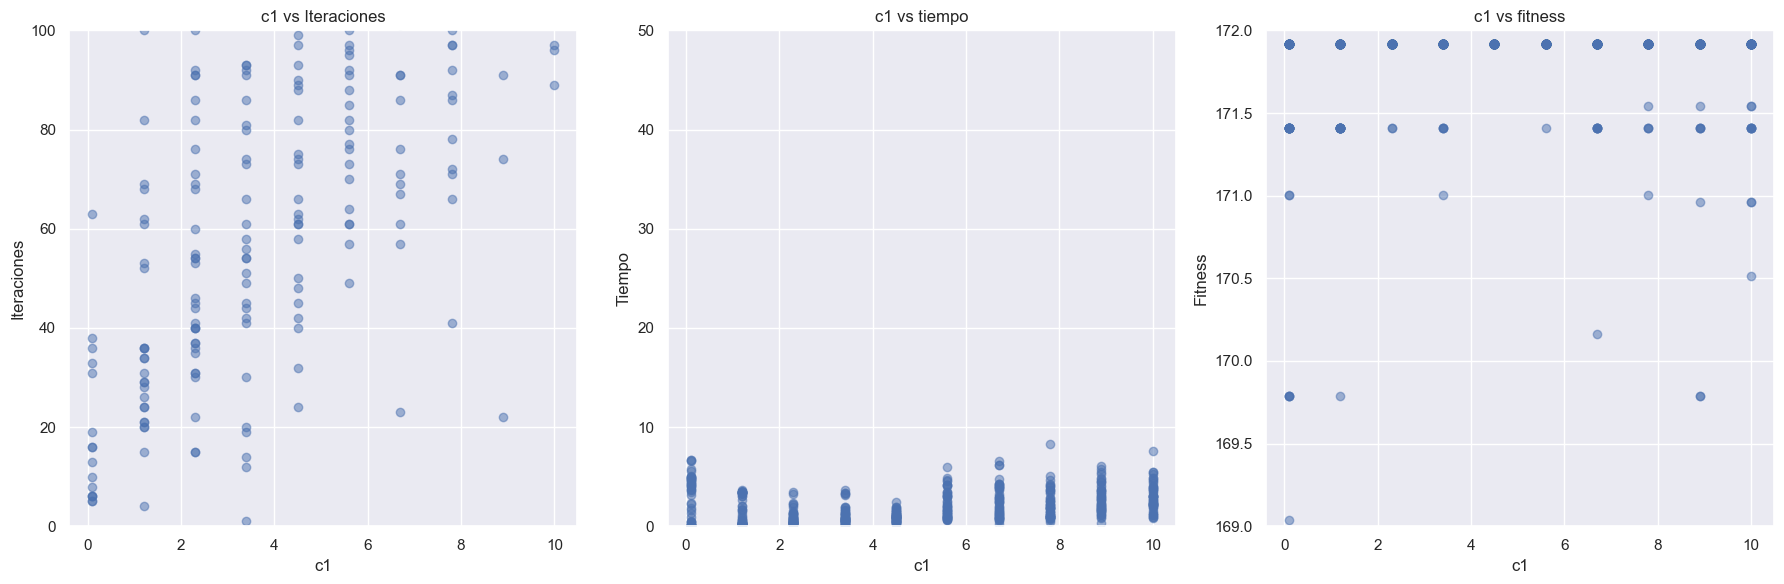

In [40]:
graficos('c1', 'resultados_pso_c1_2.csv')

In [41]:
tabla('c1', 'resultados_pso_c1_2.csv')


Estadísticas por tamaño de población:
      media_fitness  mediana_fitness  cuartil_25_fitness  cuartil_75_fitness  media_iteraciones  mediana_iteraciones  cuartil_25_iteraciones  cuartil_75_iteraciones  media_tiempo  mediana_tiempo  cuartil_25_tiempo  cuartil_75_tiempo
c1                                                                                                                                                                                                                                      
0.1      171.080131       171.918929          171.411918          171.918929             246.82                310.0                   33.75                  399.00      2.980342        3.729509           0.428121           4.715097
1.2      171.734371       171.918929          171.411918          171.918929             176.66                 91.0                   31.75                  399.00      1.550254        0.855444           0.294886           3.292951
2.3      171.898649       171

Ahora para c2

In [42]:
N = 100

c2_values = np.linspace(0.1, 10, 10, dtype=float)  # Peso cognitivo
c1 = 4.5  # Peso social

In [43]:
# Almacenamiento de resultados
resultados = []

for c2 in c2_values:
    for prueba in range(num_pruebas):
        start_time = time.time()  # Iniciar tiempo
        particles = [Particle() for _ in range(N)]

        gbest_particle = max(particles, key=lambda p: p.best_fitness)
        gbest_position = gbest_particle.best_position
        gbest_fitness = gbest_particle.best_fitness

        for it in range(it_max):
            for particle in particles:
                new_team = copy.deepcopy(particle.position)
                
                # Usamos la velocidad (número de cambios) para determinar cuántos jugadores cambiar
                indices_to_change = random.sample(range(len(new_team)), particle.velocity)

                for idx in indices_to_change:
                    player = new_team[idx]
                    pos_to_change = positions[player]
                    
                    # Filtrar candidatos para esa posición
                    # esto lo podriamos tener como una variable ya hecha, como el el algortimo de GA, y en caso de p = player seleccionamos otro y ya
                    candidates = [p for p in indices if positions[p] == pos_to_change and p != player]

                    # Asegurar que siempre haya opciones válidas
                    if not candidates:
                        candidates = [p for p in indices if positions[p] == pos_to_change]

                    # Aplicamos la actualización tipo PSO
                    if random.random() < c1 / (c1 + c2):  # Influencia del mejor local
                        new_team[idx] = particle.best_position[idx]
                    elif random.random() < c2 / (c1 + c2):  # Influencia del mejor global
                        new_team[idx] = gbest_position[idx]
                    else:  # Exploración aleatoria
                        new_team[idx] = random.choice(candidates)
                    
                #print(new_team)

                # Verificamos restricciones ANTES de calcular fitness
                total_salary = sum(salaries[player] for player in new_team)
                if total_salary <= SALARY_CAP:
                    new_fitness = fitness(new_team)
                    #print(new_fitness)

                    # Actualizar mejor posición local
                    if new_fitness > particle.best_fitness:
                        particle.best_position = new_team[:]
                        particle.best_fitness = new_fitness

                    # Actualizar mejor posición global
                    if new_fitness > gbest_fitness:
                        gbest_position = new_team[:]
                        gbest_fitness = new_fitness

            if gbest_fitness >= 171.91:  # Si se alcanza la solución óptima, detener
                break

        tiempo_ejecucion = time.time() - start_time  # Tiempo de ejecución
        resultados.append({
            'c2': c2,
            'prueba': prueba,
            'mejor_fitness': gbest_fitness,
            'iteraciones': it,
            'tiempo': tiempo_ejecucion
        })

# Guardar resultados en un DataFrame
df_resultados = pd.DataFrame(resultados)
df_resultados.to_csv('resultados_pso_c2_2.csv', index=False)

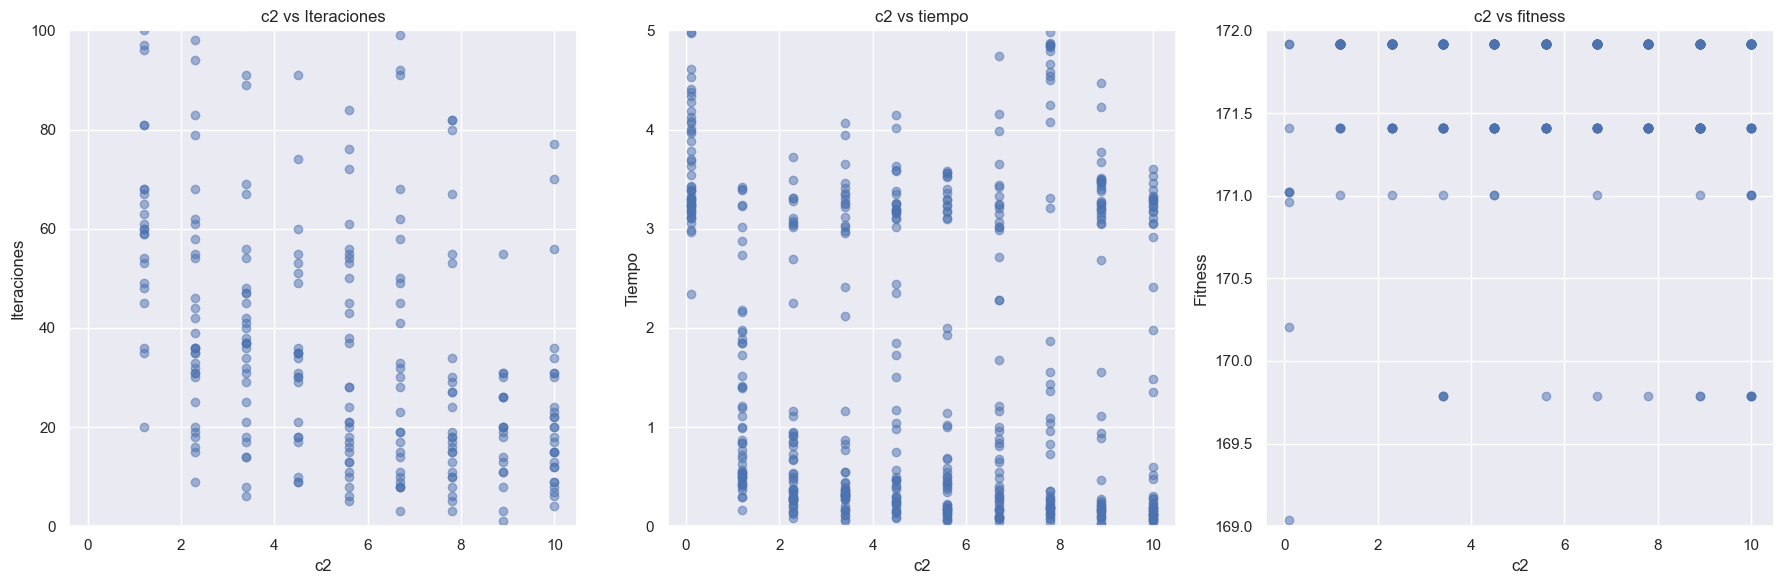

In [47]:
graficos('c2', 'resultados_pso_c2_2.csv')

In [45]:
tabla('c2', 'resultados_pso_c2_2.csv')


Estadísticas por tamaño de población:
      media_fitness  mediana_fitness  cuartil_25_fitness  cuartil_75_fitness  media_iteraciones  mediana_iteraciones  cuartil_25_iteraciones  cuartil_75_iteraciones  media_tiempo  mediana_tiempo  cuartil_25_tiempo  cuartil_75_tiempo
c2                                                                                                                                                                                                                                      
0.1      166.997927       167.426479          165.486765          168.253187             395.88                399.0                  399.00                  399.00      3.636095        3.394716           3.231192           4.053212
1.2      171.860047       171.918929          171.918929          171.918929             157.72                113.5                   61.50                  230.00      1.308775        0.927812           0.512503           1.880572
2.3      171.819486       171

rango entre 1.1 y 2.5 -> 2 puede ser un buen valor

Ahora hacemos el estudio estadístico con los valores definitivos

In [25]:
c2 = 2
c1 = 4.5
N = 100

In [7]:
# ====================== CONFIGURACIÓN PSO ======================
FITNESS_OBJETIVO = 171.918929
MAX_ITERACIONES = 100
SALARY_CAP = 30000  # Adjust based on your problem

# Rangos de parámetros PSO (dentro y fuera del rango ideal)
n_particulas_values = [25, 75, 125, 175, 225, 275, 325, 375, 425]  # Ideal:
c1_values = [1.5, 3, 4.5, 6, 7.5, 9]      # Ideal: 
c2_values = [1, 2, 3, 4, 5, 6, 7]      # Ideal: 

repeticiones = 30

In [8]:
# ====================== ALGORITMO PSO CON MEDICIÓN DE TIEMPO ======================
def ejecutar_pso_con_tiempo(N, c1, c2):
    inicio = time.time()
    
    particles =  [Particle() for _ in range(N)]
    
    gbest_particle = max(particles, key=lambda p: p.best_fitness)
    gbest_position = gbest_particle.best_position
    gbest_fitness = gbest_particle.best_fitness
    
    fitness_history = []
    
    for it in range(MAX_ITERACIONES):
        for particle in particles:
            new_team = copy.deepcopy(particle.position)
            
            indices_to_change = random.sample(range(len(new_team)), particle.velocity)
            
            for idx in indices_to_change:
                player = new_team[idx]
                pos_to_change = positions[player]
                
                if random.random() < c1 / (c1 + c2):
                    new_team[idx] = particle.best_position[idx]
                elif random.random() < c2 / (c1 + c2):
                    new_team[idx] = gbest_position[idx]
                else:
                    new_team[idx] = random.choice(jugadores_por_posicion[pos_to_change])
            
            total_salary = sum(salaries[player] for player in new_team)
            if total_salary <= SALARY_CAP:
                new_fitness = fitness(new_team)
                
                if new_fitness > particle.best_fitness:
                    particle.best_position = new_team[:]
                    particle.best_fitness = new_fitness
                
                if new_fitness > gbest_fitness:
                    gbest_position = new_team[:]
                    gbest_fitness = new_fitness
            
            particle.velocity = int(w * particle.velocity + 
                                  c1 * random.random() * (particle.best_fitness - fitness(new_team)) + 
                                  c2 * random.random() * (gbest_fitness - fitness(new_team)))
            particle.velocity = max(1, min(particle.velocity, 5))
        
        fitness_history.append(gbest_fitness)
        if gbest_fitness >= FITNESS_OBJETIVO:
            break
    
    tiempo_ejecucion = time.time() - inicio
    
    return {
        "fitness_history": fitness_history,
        "mejor_fitness": gbest_fitness,
        "iteraciones": it + 1,
        "alcanzo_optimo": gbest_fitness >= FITNESS_OBJETIVO,
        "tiempo_ejecucion": tiempo_ejecucion
    }

In [9]:
# ====================== ANÁLISIS DE SENSIBILIDAD PSO ======================
def analisis_sensibilidad_pso():
    resultados = []
    
    def agregar_resultado(param, valor, resultado, rango_ideal):
        resultados.append({
            "Parametro": param,
            "Valor": valor,
            "run": run,
            "mejor_fitness": resultado["mejor_fitness"],
            "tiempo_ejecucion": resultado["tiempo_ejecucion"],
            "iteraciones": resultado["iteraciones"],
            "alcanzo_optimo": resultado["alcanzo_optimo"],
            "en_rango": "Dentro" if rango_ideal[0] <= valor <= rango_ideal[1] else "Fuera"
        })
    
    # 1. Variar número de partículas
    print("Variando número de partículas...")
    for n_particulas in tqdm(n_particulas_values):
        for run in range(repeticiones):
            resultado = ejecutar_pso_con_tiempo(n_particulas, 4.5, 2.0)
            agregar_resultado("n_particulas", n_particulas, resultado, (90, 150))
    
    # 2. Variar c1
    print("Variando c1...")
    for c1 in tqdm(c1_values):
        for run in range(repeticiones):
            resultado = ejecutar_pso_con_tiempo(125, c1, 2.0)
            agregar_resultado("c1", c1, resultado, (2.0, 5.0))
    
    # 3. Variar c2
    print("Variando c2...")
    for c2 in tqdm(c2_values):
        for run in range(repeticiones):
            resultado = ejecutar_pso_con_tiempo(125, 4.5, c2)
            agregar_resultado("c2", c2, resultado, (1.1, 2.5))
    
    return pd.DataFrame(resultados)

In [4]:
# ====================== ANÁLISIS ESTADÍSTICO COMPLETO PSO ======================
def analisis_estadistico_completo_pso(df):
    print("\n=== Análisis por Parámetro PSO ===")
    
    for param in ['n_particulas', 'c1', 'c2']:
        print(f"\n---- {param.upper()} ----")
        df_param = df[df['Parametro'] == param]
        
        # Fitness: Dentro vs Fuera del rango
        dentro_fit = df_param[df_param['en_rango'] == 'Dentro']['mejor_fitness']
        fuera_fit = df_param[df_param['en_rango'] == 'Fuera']['mejor_fitness']
        h_fit, p_fit = kruskal(dentro_fit, fuera_fit)
        
        # Tiempo: Dentro vs Fuera del rango
        dentro_tiempo = df_param[df_param['en_rango'] == 'Dentro']['tiempo_ejecucion']
        fuera_tiempo = df_param[df_param['en_rango'] == 'Fuera']['tiempo_ejecucion']
        h_tiempo, p_tiempo = kruskal(dentro_tiempo, fuera_tiempo)
        
        print(f"FITNESS - H: {h_fit:.3f}, p-valor: {p_fit:.4f}")
        print(f"TIEMPO - H: {h_tiempo:.3f}, p-valor: {p_tiempo:.4f}")
        
        # Resumen estadístico detallado
        print("\nResumen estadístico:")
        print(df_param.groupby('en_rango').agg({
            'mejor_fitness': ['mean', 'std', 'median', 'min', 'max'],
            'tiempo_ejecucion': ['mean', 'std', 'median'],
            'iteraciones': ['mean', 'median'],
            'alcanzo_optimo': 'sum'
        }))

In [5]:
# ====================== VISUALIZACIÓN PSO ======================
def visualizacion_pso(df):
    plt.figure(figsize=(20, 15))
    
    # Gráficos de fitness
    plt.subplot(2, 3, 1)
    sns.boxplot(data=df[df['Parametro'] == 'n_particulas'], 
                x='Valor', y='mejor_fitness', hue='en_rango')
    plt.title("Fitness - Número de Partículas")
    plt.axhline(FITNESS_OBJETIVO, color='r', linestyle='--')
    
    plt.subplot(2, 3, 2)
    sns.boxplot(data=df[df['Parametro'] == 'c1'], 
                x='Valor', y='mejor_fitness', hue='en_rango')
    plt.title("Fitness - c1")
    plt.axhline(FITNESS_OBJETIVO, color='r', linestyle='--')
    
    plt.subplot(2, 3, 3)
    sns.boxplot(data=df[df['Parametro'] == 'c2'], 
                x='Valor', y='mejor_fitness', hue='en_rango')
    plt.title("Fitness - c2")
    plt.axhline(FITNESS_OBJETIVO, color='r', linestyle='--')
    
    # Gráficos de tiempo
    plt.subplot(2, 3, 4)
    sns.boxplot(data=df[df['Parametro'] == 'n_particulas'], 
                x='Valor', y='tiempo_ejecucion', hue='en_rango')
    plt.title("Tiempo - Número de Partículas")
    
    plt.subplot(2, 3, 5)
    sns.boxplot(data=df[df['Parametro'] == 'c1'], 
                x='Valor', y='tiempo_ejecucion', hue='en_rango')
    plt.title("Tiempo - c1")
    
    plt.subplot(2, 3, 6)
    sns.boxplot(data=df[df['Parametro'] == 'c2'], 
                x='Valor', y='tiempo_ejecucion', hue='en_rango')
    plt.title("Tiempo - c2")
    
    plt.tight_layout()
    plt.show()

Variando número de partículas...


100%|██████████| 9/9 [00:55<00:00,  6.16s/it]


Variando c1...


100%|██████████| 6/6 [00:29<00:00,  4.91s/it]


Variando c2...


100%|██████████| 7/7 [00:30<00:00,  4.41s/it]



=== Análisis por Parámetro PSO ===

---- N_PARTICULAS ----
FITNESS - H: 0.570, p-valor: 0.4504
TIEMPO - H: 3.395, p-valor: 0.0654

Resumen estadístico:
         mejor_fitness                                               tiempo_ejecucion                     iteraciones        alcanzo_optimo
                  mean       std      median         min         max             mean       std    median        mean median            sum
en_rango                                                                                                                                   
Dentro      171.885128  0.128633  171.918929  171.411918  171.918929         0.156813  0.134151  0.102773      45.500   35.0             28
Fuera       171.771357  0.590368  171.918929  167.672295  171.918929         0.211167  0.171061  0.163140      39.325   27.0            214

---- C1 ----
FITNESS - H: 3.174, p-valor: 0.0748
TIEMPO - H: 6.622, p-valor: 0.0101

Resumen estadístico:
         mejor_fitness                  

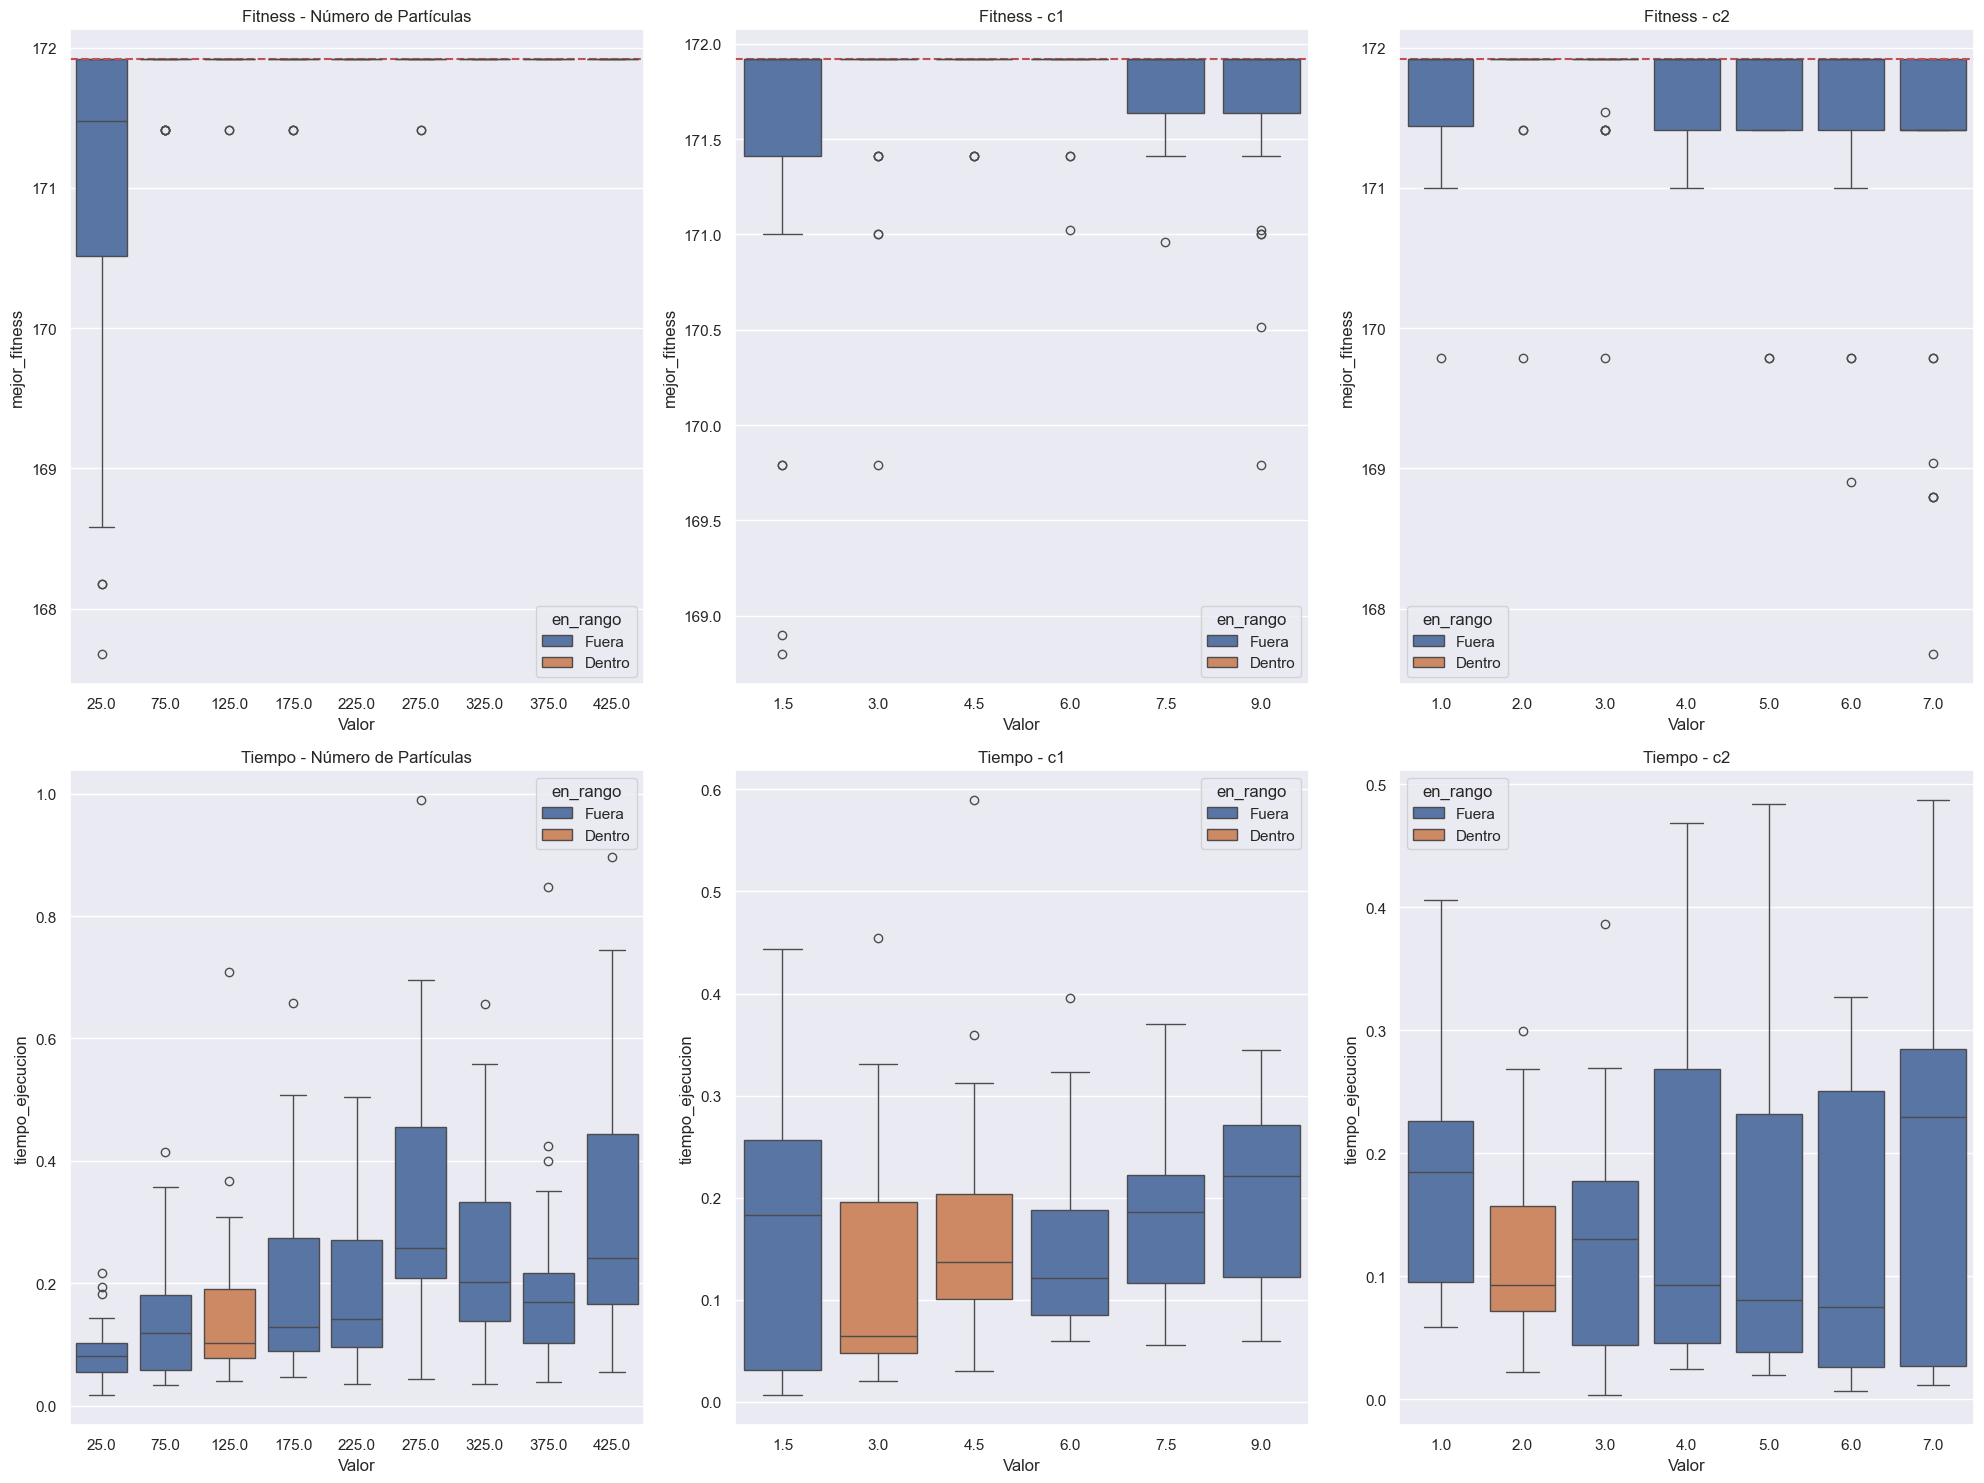


=== Resumen de ejecuciones óptimas PSO ===
Parametro     Valor  en_rango
c1            1.5    Fuera       17
              3.0    Dentro      24
              4.5    Dentro      27
              6.0    Fuera       27
              7.5    Fuera       22
              9.0    Fuera       22
c2            1.0    Fuera       21
              2.0    Dentro      27
              3.0    Fuera       24
              4.0    Fuera       21
              5.0    Fuera       20
              6.0    Fuera       20
              7.0    Fuera       13
n_particulas  25.0   Fuera       14
              75.0   Fuera       25
              125.0  Dentro      28
              175.0  Fuera       27
              225.0  Fuera       30
              275.0  Fuera       28
              325.0  Fuera       30
              375.0  Fuera       30
              425.0  Fuera       30
Name: alcanzo_optimo, dtype: int64


In [105]:
# ====================== EJECUCIÓN PRINCIPAL PSO ======================
# Ejecutar análisis PSO
df_resultados_pso = analisis_sensibilidad_pso()

# Guardar resultados
df_resultados_pso.to_csv("resultados_pso11.csv", index=False)
    
# Análisis estadístico completo
analisis_estadistico_completo_pso(df_resultados_pso)

# Visualización
visualizacion_pso(df_resultados_pso)

# Resumen ejecuciones óptimas
print("\n=== Resumen de ejecuciones óptimas PSO ===")
print(df_resultados_pso.groupby(['Parametro', 'Valor', 'en_rango'])['alcanzo_optimo'].sum())


=== Análisis por Parámetro PSO ===

---- N_PARTICULAS ----
FITNESS - H: 0.570, p-valor: 0.4504
TIEMPO - H: 3.395, p-valor: 0.0654

Resumen estadístico:
         mejor_fitness                                                \
                  mean       std      median         min         max   
en_rango                                                               
Dentro      171.885128  0.128633  171.918929  171.411918  171.918929   
Fuera       171.771357  0.590368  171.918929  167.672295  171.918929   

         tiempo_ejecucion                     iteraciones         \
                     mean       std    median        mean median   
en_rango                                                           
Dentro           0.156813  0.134151  0.102773      45.500   35.0   
Fuera            0.211167  0.171061  0.163140      39.325   27.0   

         alcanzo_optimo  
                    sum  
en_rango                 
Dentro               28  
Fuera               214  

---- C1 ----
F

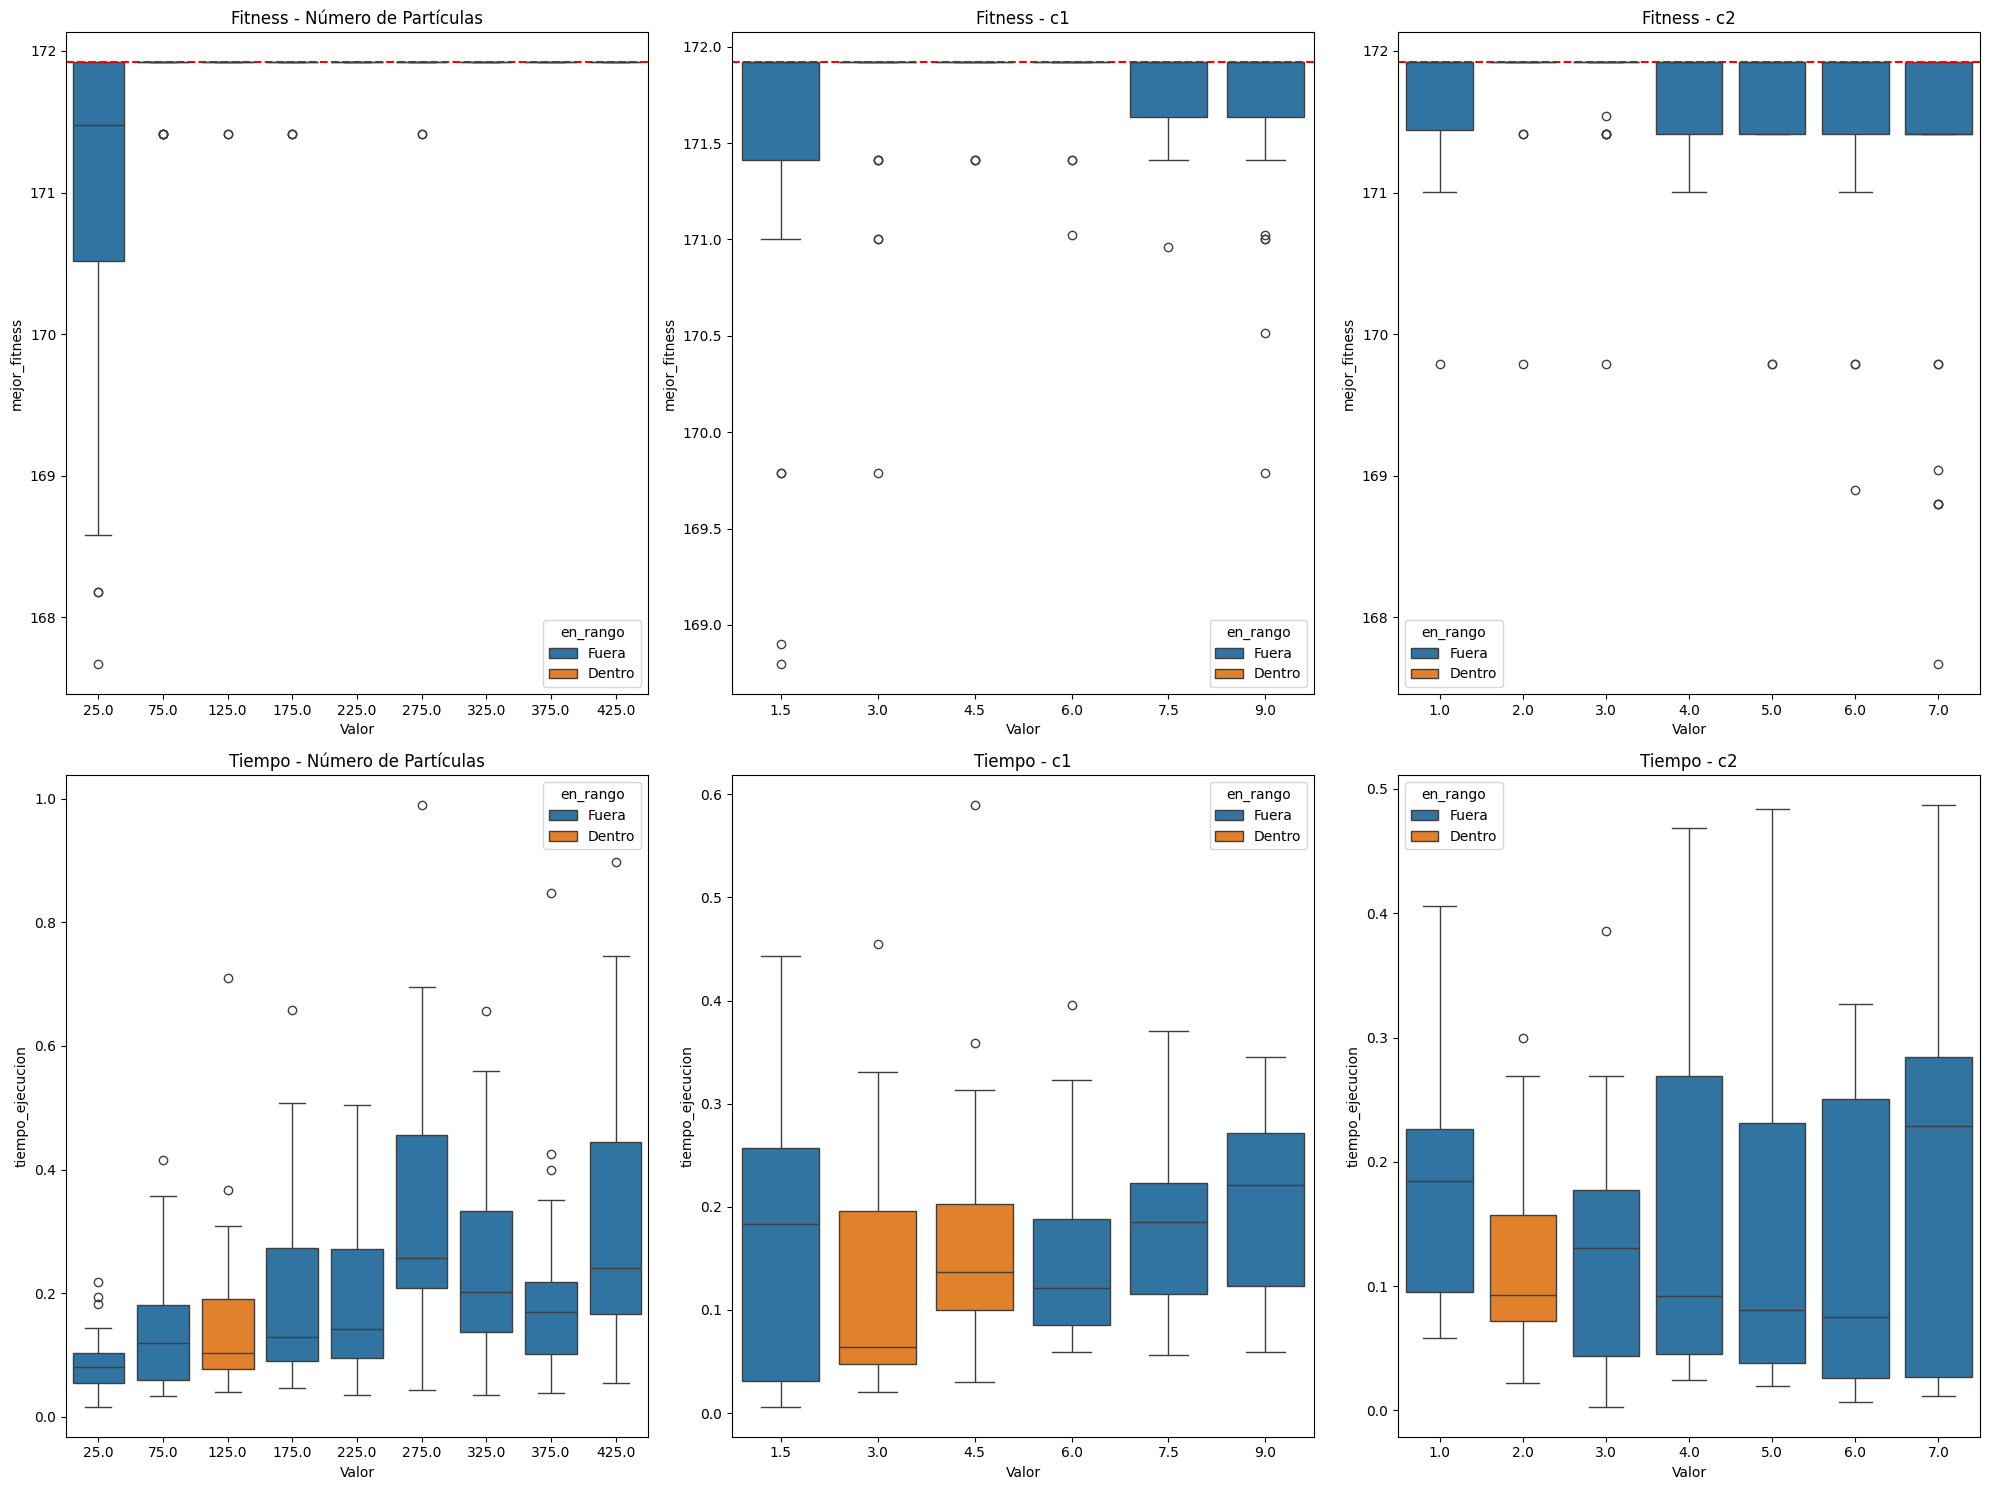


=== Resumen de ejecuciones óptimas PSO ===
Parametro     Valor  en_rango
c1            1.5    Fuera       17
              3.0    Dentro      24
              4.5    Dentro      27
              6.0    Fuera       27
              7.5    Fuera       22
              9.0    Fuera       22
c2            1.0    Fuera       21
              2.0    Dentro      27
              3.0    Fuera       24
              4.0    Fuera       21
              5.0    Fuera       20
              6.0    Fuera       20
              7.0    Fuera       13
n_particulas  25.0   Fuera       14
              75.0   Fuera       25
              125.0  Dentro      28
              175.0  Fuera       27
              225.0  Fuera       30
              275.0  Fuera       28
              325.0  Fuera       30
              375.0  Fuera       30
              425.0  Fuera       30
Name: alcanzo_optimo, dtype: int64


In [10]:
# Guardar resultados
df_resultados_pso = pd.read_csv("resultados_pso11.csv")
    
# Análisis estadístico completo
analisis_estadistico_completo_pso(df_resultados_pso)

# Visualización
visualizacion_pso(df_resultados_pso)

# Resumen ejecuciones óptimas
print("\n=== Resumen de ejecuciones óptimas PSO ===")
print(df_resultados_pso.groupby(['Parametro', 'Valor', 'en_rango'])['alcanzo_optimo'].sum())

In [124]:
def calcular_pvalor_particulas(df):
    """
    Calcula el p-valor comparando:
    - Grupo A: 90 < n_particulas <= 150
    - Grupo B: n_particulas > 150
    """
    # Filtrar datos de PSO solo para el parámetro n_particulas
    df_pso = df[(df['Parametro'] == 'n_particulas')].copy()
    
    # Crear grupos
    grupo_a = df_pso[(df_pso['Valor'] > 90) & (df_pso['Valor'] <= 150)]['tiempo_ejecucion']
    grupo_b = df_pso[df_pso['Valor'] > 150]['tiempo_ejecucion']
    
    # Test de Kruskal-Wallis
    h_stat, p_valor = kruskal(grupo_a, grupo_b)
    
    # Resultados
    print(f"Comparación de fitness (90-150 partículas vs >150):")
    print(f"  - H-statistic: {h_stat:.3f}")
    print(f"  - p-valor: {p_valor:.4f}")
    
    # Interpretación básica
    if p_valor < 0.05:
        print("\n Hay diferencia significativa (p < 0.05)")
    else:
        print("\n No hay diferencia significativa (p ≥ 0.05)")
    
    return h_stat, p_valor

In [125]:
calcular_pvalor_particulas(df_resultados_pso)

Comparación de fitness (90-150 partículas vs >150):
  - H-statistic: 9.706
  - p-valor: 0.0018

 Hay diferencia significativa (p < 0.05)


(9.706161137440745, 0.0018365124751736413)

In [126]:
def calcular_pvalor_particulas2(df):
    """
    Calcula el p-valor comparando:
    - Grupo A: 90 < n_particulas <= 150
    - Grupo B: n_particulas > 150
    """
    # Filtrar datos de PSO solo para el parámetro n_particulas
    df_pso = df[(df['Parametro'] == 'n_particulas')].copy()
    
    # Crear grupos
    grupo_a = df_pso[(df_pso['Valor'] > 90) & (df_pso['Valor'] <= 150)]['mejor_fitness']
    grupo_b = df_pso[df_pso['Valor'] < 90]['mejor_fitness']
    
    # Test de Kruskal-Wallis
    h_stat, p_valor = kruskal(grupo_a, grupo_b)
    
    # Resultados
    print(f"Comparación de fitness (90-150 partículas vs >150):")
    print(f"  - H-statistic: {h_stat:.3f}")
    print(f"  - p-valor: {p_valor:.4f}")
    
    # Interpretación básica
    if p_valor < 0.05:
        print("\n Hay diferencia significativa (p < 0.05)")
    else:
        print("\n No hay diferencia significativa (p ≥ 0.05)")
    
    return h_stat, p_valor

In [127]:
calcular_pvalor_particulas2(df_resultados_pso)

Comparación de fitness (90-150 partículas vs >150):
  - H-statistic: 8.845
  - p-valor: 0.0029

 Hay diferencia significativa (p < 0.05)


(8.844748447990074, 0.0029393340731150137)

# Códgio para las comparaciones

In [31]:
repeticiones = 200

In [32]:
# ====================== PARA LAS COMPARCIONES ======================
def pso():
    resultados = []
    
    def agregar_resultado(resultado):
        resultados.append({
            "Modelo": 'PSO',
            "run": run,
            "mejor_fitness": resultado["mejor_fitness"],
            "tiempo_ejecucion": resultado["tiempo_ejecucion"],
            "alcanzo_optimo": resultado["alcanzo_optimo"]
        })
    
    # Variar PSO
    print("Ejecutando PSO...")
    for run in range(repeticiones):
        resultado = ejecutar_pso_con_tiempo(125, 4.5, 2.0)
        agregar_resultado(resultado)
    
    return pd.DataFrame(resultados)

In [33]:
df_resultados_pso = pso()

df_resultados_pso.to_csv("comparacion_prueba.csv", mode='a', index=False)

Ejecutando PSO...
